# Adversarial Variational Bayes

AAE 와 마찬가지로, (VAE 에서의) 특정한 posterior density 가정 => KL-divergence 대신 adversarial loss 를 사용하여 임의의 posterior density 를 사용할 수 있게 함.

### What is different with AAEs?

* https://www.reddit.com/r/MachineLearning/comments/5p9ism/d_thoughts_on_adversarial_variational_bayes/
* 별다를 건 없는듯... 다만 AVB 가 훨씬 이론적 배경이 탄탄한 것 같다.
* 샘플링 또한 AAE 에서는 생략하지만 AVB 에서는 엡실론을 인코더에 집어넣어서 살려줌
* 자세한 건 논문을 상세히 읽어보고 비교해봐야겠지만 여기서는 구현만 해보고 가볍게 넘어가자.

라고 생각했는데, 보다 보니 이론적인 정리를 위해 좀더 자세히 볼 가치가 있는 논문인 듯.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
def show_plot(samples):
    fig = plot(samples)
    plt.show()
    plt.close(fig)

In [22]:
x_dim = 784
h_dim = 128
z_dim = 10
eps_dim = 4

In [71]:
# 참고: 원래 variable_scope 에 reuse 를 걸어주면 되야하는데, 이게 구버전이라서 안됨. 1.1에선 그냥 scope 에 걸면 된다!
def dense_layer(inputs, units, activ_fn=None, w_init=tf.contrib.layers.xavier_initializer(), reuse=False):
    return tf.layers.dense(inputs, units, activation=activ_fn, weights_initializer=w_init, reuse=reuse)

In [25]:
# q(z|x, eps)
def encoder(x, eps):
    with tf.variable_scope("encoder"):
        # x: [None, 784]
        # eps: [None, ?]
        net = tf.concat([x, eps], axis=1)
        net = dense_layer(net, h_dim, activ_fn=tf.nn.relu)
        net = dense_layer(net, h_dim, activ_fn=tf.nn.relu)
        z = dense_layer(net, z_dim)
    
    return z

In [41]:
# p(x|z)
def decoder(z, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        # z: [None, z_dim]
        net = dense_layer(z, h_dim, activ_fn=tf.nn.relu, reuse=reuse)
        net = dense_layer(net, h_dim, activ_fn=tf.nn.relu, reuse=reuse)
        logits = dense_layer(net, x_dim, reuse=reuse)
        prob = tf.nn.sigmoid(logits)
    
    return prob, logits

In [40]:
# D: (x,z) / (x,z_)
# z 는 prior
# z_ 는 inference model (encoder) 에서 학습한 z_
# x 를 같이 넣는 이유는 수학적인것때문인듯...
# Optimal D(x,z) = T(x,z) = log q(z|x) - log p(z)
def D(x, z, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        # x: [None, 784]
        # z: [None, z_dim]
        net = tf.concat([x, z], axis=1)
        net = dense_layer(net, h_dim, activ_fn=tf.nn.relu, reuse=reuse)
        logits = dense_layer(net, 1, reuse=reuse)
    
    return logits

In [53]:
# build graph
tf.reset_default_graph()

# inputs
X = tf.placeholder(tf.float32, shape=[None, x_dim])
Z = tf.placeholder(tf.float32, shape=[None, z_dim])
eps = tf.placeholder(tf.float32, shape=[None, eps_dim])

# AE
z_ = encoder(X, eps)
x_prob, x_logits = decoder(z_)
# D_ = D(X, z_) # AVB 는 q graident 를 계산할 때 이걸 씀 => D_logits_fake 를 활용해도 될거 같은데?

# adversarial loss (GAN)
D_logits_real = D(X, Z)
D_logits_fake = D(X, z_, reuse=True)
D_prob_real = tf.nn.sigmoid(D_logits_real)
D_prob_fake = tf.nn.sigmoid(D_logits_fake)

# 보통 adversarial loss 를 계산할 때 퍼포먼스를 위해 tf 에서 제공하는 최적화된 sigmoid_CE 를 쓰지만, 여기서는 헷갈리니 그냥 논문대로 짠다.
# 즉 sigmoid 를 따로 계산해서 쓰겠다는 말

"""
여기는 논문의 algorithm 1.
이게 어떻게 아래와 같이 구현되는지는 대충은 알겠는데 확실히는 논문을 더 읽어봐야함

# encoder loss (theta)
# log p(x|z_)
# encoder_loss = log(x_prob)

# decoder loss (phi)
# -T(x,z_) + log p(x,z_)
# decoder_loss = -D_logits_fake + log(x_prob)

# adversarial loss (psi)
# log sigmoid(T(x,z_)) + log 1-sigmoid(T(x,z))
# adversarial_loss = log D_prob_fake + log 1-D_prob_real
"""

disc = tf.reduce_mean(-D_logits_fake) # -D(x,z_)
# log decoder(z_) for bernoulli dist.
nll = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=X), axis=1) 
loglike = -tf.reduce_mean(nll)

# 디코더 로스에 인코더 로스가 포함되어 있긴 한데... 훔.. 논문을더자세히봐야...
elbo = disc + loglike # decoder loss
D_loss = tf.reduce_mean(tf.log(D_prob_fake + 1e-8) + tf.log(1-D_prob_real + 1e-8)) # adversarial loss

var_encoder = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
var_decoder = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
var_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

train_op_AE = tf.train.AdamOptimizer().minimize(-elbo, var_list=var_encoder+var_decoder)
train_op_D = tf.train.AdamOptimizer().minimize(-D_loss, var_list=var_D)

In [54]:
# graph for sampling
x_gen_from_z, _ = decoder(Z, reuse=True)

[1/200] elbo: -166.7331, adversarial_loss: -1.0447


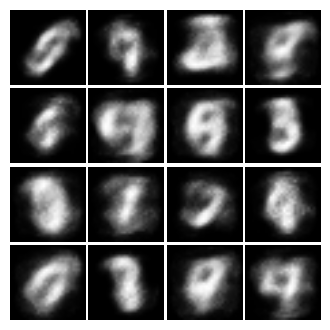

[10/200] elbo: -94.5339, adversarial_loss: -0.1447


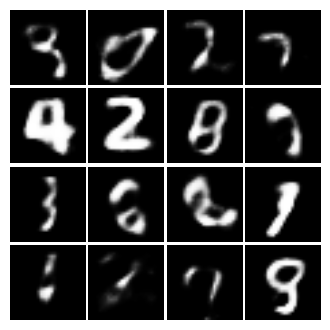

[20/200] elbo: -91.6060, adversarial_loss: -0.0838


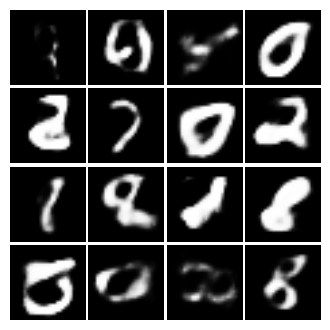

[30/200] elbo: -91.2728, adversarial_loss: -0.0689


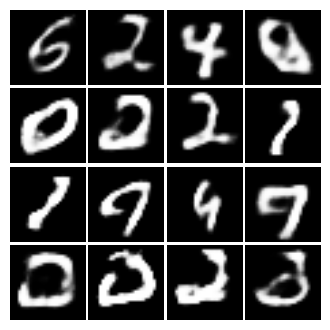

[40/200] elbo: -90.4697, adversarial_loss: -0.0818


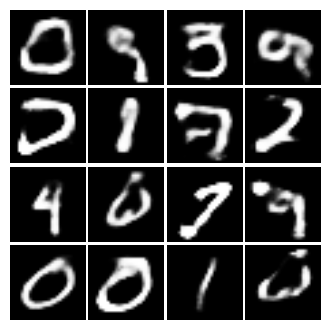

[50/200] elbo: -89.6873, adversarial_loss: -0.0867


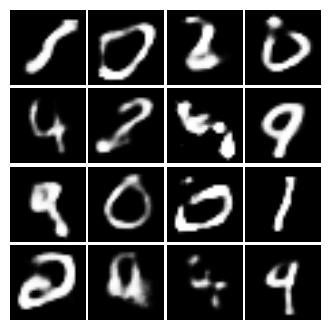

[60/200] elbo: -88.9606, adversarial_loss: -0.0929


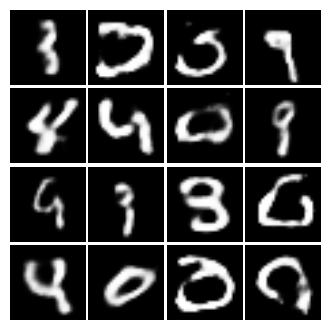

[70/200] elbo: -88.4565, adversarial_loss: -0.0910


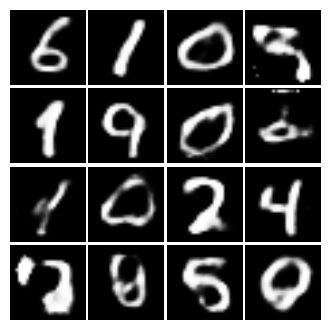

[80/200] elbo: -88.1318, adversarial_loss: -0.0869


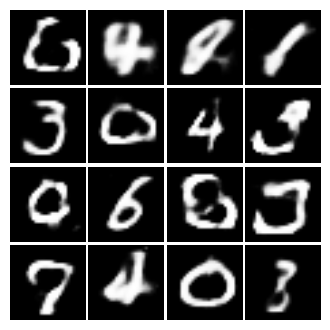

[90/200] elbo: -88.0807, adversarial_loss: -0.0964


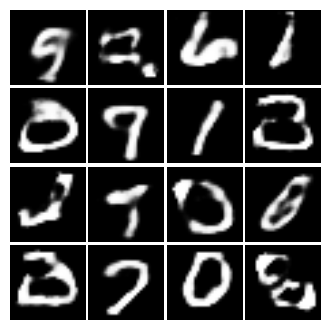

[100/200] elbo: -87.5117, adversarial_loss: -0.0910


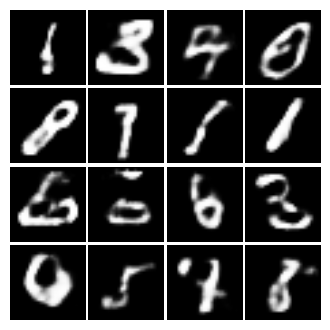

[110/200] elbo: -87.3657, adversarial_loss: -0.0998


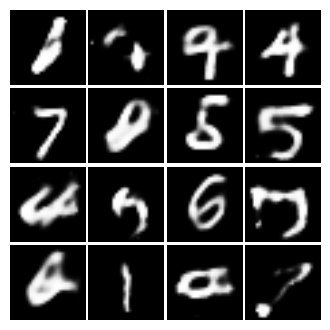

[120/200] elbo: -87.1506, adversarial_loss: -0.0927


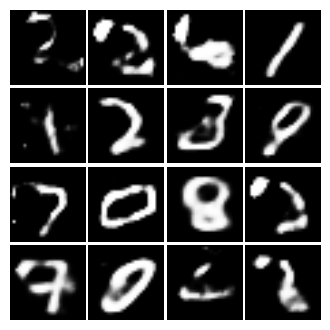

[130/200] elbo: -87.0544, adversarial_loss: -0.0990


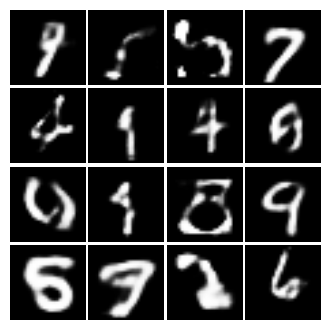

[140/200] elbo: -86.6868, adversarial_loss: -0.0908


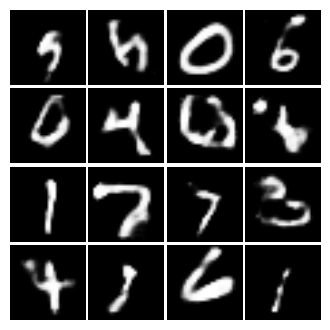

[150/200] elbo: -86.2507, adversarial_loss: -0.1009


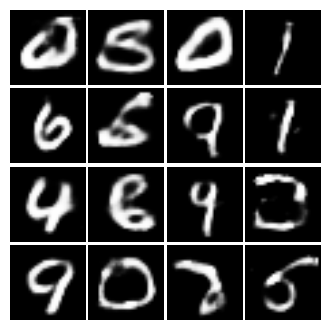

[160/200] elbo: -86.1429, adversarial_loss: -0.1016


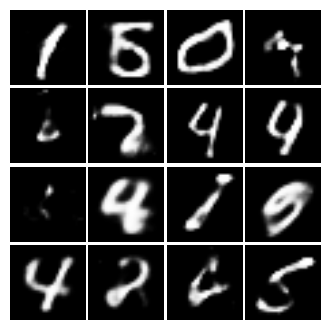

[170/200] elbo: -86.1230, adversarial_loss: -0.0973


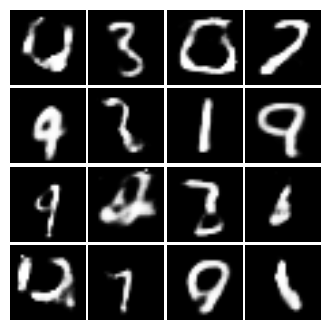

[180/200] elbo: -85.8493, adversarial_loss: -0.1034


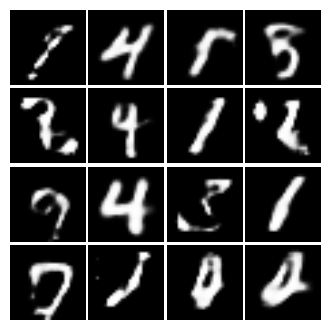

[190/200] elbo: -85.7534, adversarial_loss: -0.0934


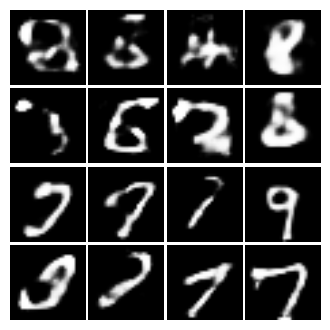

[200/200] elbo: -85.8163, adversarial_loss: -0.1113


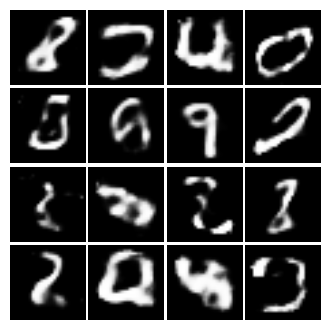

In [55]:
epoch_n = 200
batch_size = 128
N = mnist.train.num_examples

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./tmp/", sess.graph)
global_step = 0

for epoch in range(epoch_n):
    elbo_avg = 0
    D_loss_avg = 0
    for _ in range(N // batch_size):
        global_step += 1
        X_batch, _ = mnist.train.next_batch(batch_size)
        Z_batch = np.random.randn(batch_size, z_dim)
        eps_batch = np.random.randn(batch_size, eps_dim)
        _, elbo_cur = sess.run([train_op_AE, elbo], {X: X_batch, Z: Z_batch, eps: eps_batch})
        _, D_loss_cur = sess.run([train_op_D, D_loss], {X: X_batch, Z: Z_batch, eps: eps_batch})
        elbo_avg += elbo_cur
        D_loss_avg += D_loss_cur
#         writer.add_summary(summary_cur, global_step)
    
    if epoch == 0 or (epoch+1) % 10 == 0:
        elbo_avg /= (N // batch_size)
        D_loss_avg /= (N // batch_size)
        print("[{}/{}] elbo: {:.4f}, adversarial_loss: {:.4f}".format(epoch+1, epoch_n, elbo_avg, D_loss_avg))
        samples = sess.run(x_gen_from_z, {Z: np.random.randn(16, z_dim)}) 
        show_plot(samples)

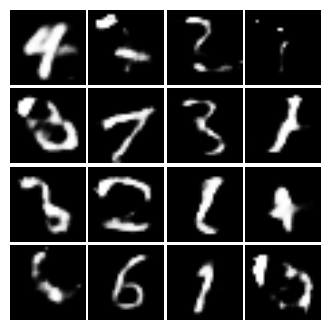

In [57]:
samples = sess.run(x_gen_from_z, {Z: np.random.randn(16, z_dim)}) 
show_plot(samples)

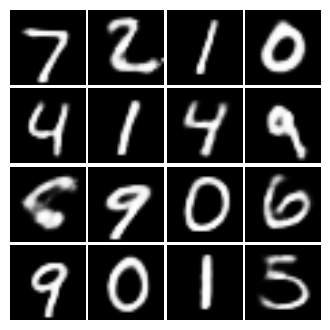

In [60]:
samples = sess.run(x_prob, {X: mnist.test.images[:16], eps: np.random.randn(16, eps_dim)})
show_plot(samples)

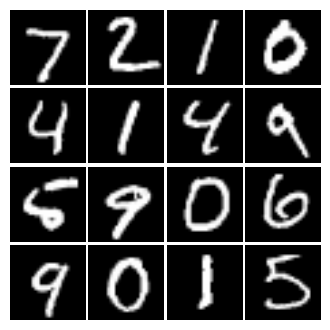

In [61]:
show_plot(mnist.test.images[:16])

# Latent space walking

In [62]:
def interpolate(st, ed, n=16):
    diff = ed - st
    step = diff / n
    return np.array([st + step*i for i in range(n)])

In [63]:
encoded_z = sess.run(z_, {X: mnist.test.images[:16], eps: np.random.randn(16, eps_dim)})

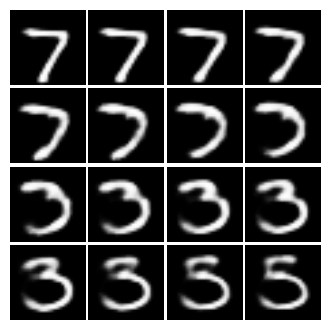

In [70]:
walking_z = interpolate(encoded_z[0], encoded_z[15])
samples = sess.run(x_gen_from_z, {Z: walking_z})
show_plot(samples)

# Conclusion

* 논문을 읽어보자.
* AAE 와는 결과가 확실히 좀 다르네...
* 너무 자세히 알려고 하지는 말고 이론적 토대를 쌓는 느낌으로 읽자.
* 암튼 좀 살펴보아야 할 듯.